## Import Data

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas_ta as ta

df_raw = pd.read_csv('spy.csv')

In [26]:
df_raw.head()

,Date,Open,High,Low,Close,Volume,Day,Weekday,Week,Month,Year
0,1993-01-29,25.236158,25.236158,25.110605,25.218222,1003200,29,4,4,1,1993
1,1993-02-01,25.236146,25.397572,25.236146,25.397572,480500,1,0,5,2,1993
2,1993-02-02,25.379673,25.469354,25.325865,25.451418,201300,2,1,5,2,1993
3,1993-02-03,25.487270,25.738376,25.469334,25.720440,529400,3,2,5,2,1993
4,1993-02-04,25.810132,25.881876,25.523153,25.828068,531500,4,3,5,2,1993


In [27]:
df_raw['avg'] = (df_raw['High'] + df_raw['Low']) / 2 

df_raw['Tmrw_avg'] = df_raw['avg'].shift(-1)
df_raw['RSI'] = ta.rsi(df_raw.Close, length=15)
df_raw['EMAF'] = ta.ema(df_raw.Close, length=20)
df_raw['EMAM'] = ta.ema(df_raw.Close, length=100)
df_raw['EMAS'] = ta.ema(df_raw.Close, length=150)

df_raw.dropna(inplace=True)
df_raw.reset_index(drop=True, inplace=True)

In [28]:
import datetime

def str_to_datetime(s):
    split = s.split('-')
    year, month, day = int(split[0]), int(split[1]), int(split[2])
    return datetime.datetime(year=year, month=month, day=day)

df_raw['Date'] = df_raw['Date'].apply(str_to_datetime)

df_raw.head()

,Date,Open,High,Low,Close,Volume,Day,Weekday,Week,Month,Year,avg,Tmrw_avg,RSI,EMAF,EMAM,EMAS
0,1993-09-01,26.950641,27.059533,26.950641,27.005087,136500,1,2,35,9,1993,27.005087,26.977861,73.860313,26.625405,26.106154,25.902142
1,1993-09-02,27.023232,27.059530,26.896192,26.914341,472400,2,3,35,9,1993,26.977861,26.914327,67.949468,26.652923,26.122157,25.915548
2,1993-09-03,26.896179,26.968773,26.859882,26.932476,630500,3,4,35,9,1993,26.914327,26.841744,68.489414,26.679547,26.138203,25.929018
3,1993-09-07,26.932487,26.968784,26.714704,26.751001,196400,7,1,36,9,1993,26.841744,26.614886,58.011208,26.686352,26.150338,25.939905
4,1993-09-08,26.751000,26.751000,26.478772,26.660257,269900,8,2,36,9,1993,26.614886,26.642101,53.616527,26.683867,26.160435,25.949446


In [42]:
df_raw['pct_change'] = (df_raw['Tmrw_avg']/df_raw['avg'] - 1) * 100
df_raw['Pos_change'] = df_raw['pct_change'].apply(lambda x: 1 if x > 0 else 0)

df_raw.head()

,Date,Open,High,Low,Close,Volume,Day,Weekday,Week,Month,Year,avg,Tmrw_avg,RSI,EMAF,EMAM,EMAS,pct_change,Pos_change
0,1993-09-01,26.950641,27.059533,26.950641,27.005087,136500,1,2,35,9,1993,27.005087,26.977861,73.860313,26.625405,26.106154,25.902142,-0.100818,0
1,1993-09-02,27.023232,27.059530,26.896192,26.914341,472400,2,3,35,9,1993,26.977861,26.914327,67.949468,26.652923,26.122157,25.915548,-0.235502,0
2,1993-09-03,26.896179,26.968773,26.859882,26.932476,630500,3,4,35,9,1993,26.914327,26.841744,68.489414,26.679547,26.138203,25.929018,-0.269683,0
3,1993-09-07,26.932487,26.968784,26.714704,26.751001,196400,7,1,36,9,1993,26.841744,26.614886,58.011208,26.686352,26.150338,25.939905,-0.845170,0
4,1993-09-08,26.751000,26.751000,26.478772,26.660257,269900,8,2,36,9,1993,26.614886,26.642101,53.616527,26.683867,26.160435,25.949446,0.102254,1


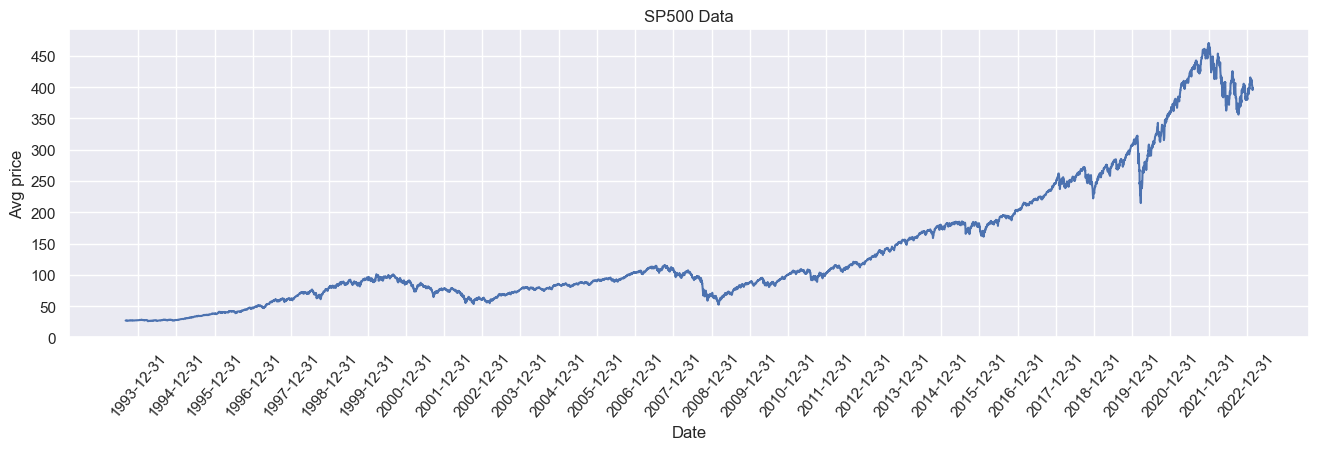

In [29]:
import seaborn as sns
from matplotlib.dates import DateFormatter

date_form = DateFormatter('%Y-%m-%d')

sns.set(rc={'figure.figsize':(16, 4)})
ax = sns.lineplot(x=df_raw['Date'], y=df_raw['avg'])
ax.set_yticks(range(0, 500, 50))
plt.title('SP500 Data')
plt.xlabel('Date')
plt.ylabel('Avg price')
plt.xticks(pd.date_range(df_raw['Date'].min(), df_raw['Date'].max(), freq='Y'), rotation=50)
plt.gca().xaxis.set_major_formatter(date_form)
plt.show()

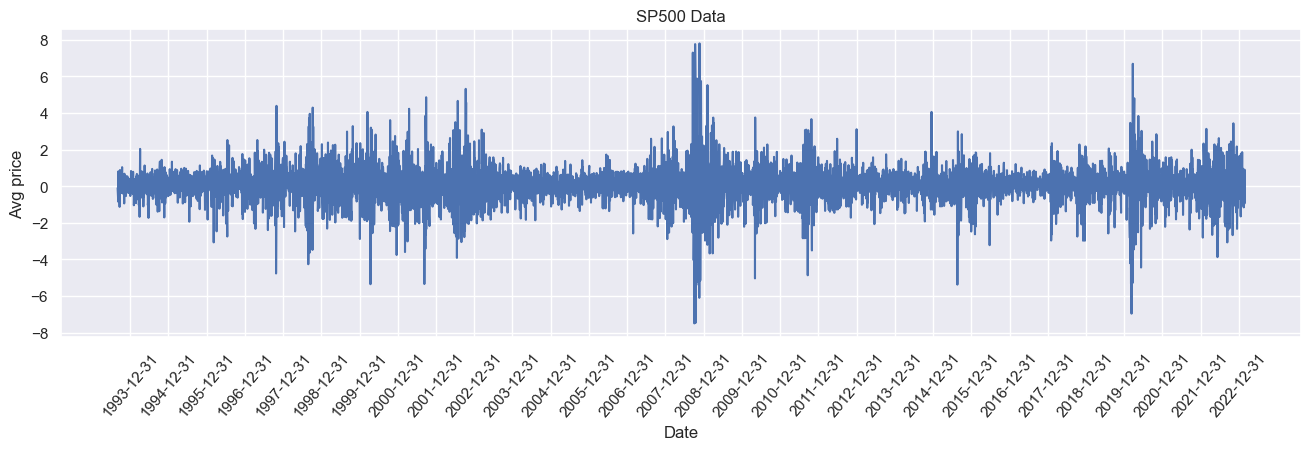

In [44]:
sns.set(rc={'figure.figsize':(16, 4)})
ax = sns.lineplot(x=df_raw['Date'], y=df_raw['pct_change'])
plt.title('SP500 Data')
plt.xlabel('Date')
plt.ylabel('Avg price')
plt.xticks(pd.date_range(df_raw['Date'].min(), df_raw['Date'].max(), freq='Y'), rotation=50)
plt.gca().xaxis.set_major_formatter(date_form)
plt.show()

## LSTM

In [30]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [31]:
def rmse_calc(y_true, y_pred):
    rmse = np.sqrt(np.mean((y_true - y_pred)**2))
    return rmse

def mape_calc(y_true, y_pred):
    y_pred = np.array(y_pred)
    y_true = np.array(y_true)
    mape = np.mean(np.abs((y_true - y_pred) / y_true))*100
    return mape

In [32]:
split = int(len(df_raw)*.8)

x = df_raw.drop(['Tmrw_avg'], axis=1)
y = df_raw['Tmrw_avg']
y = y.values.reshape(-1,1)

x_train, x_test = x[:split], x[split:]
y_train, y_test = y[:split], y[split:]

train_dates = x_train['Date']
test_dates = x_test['Date']
x_test = x_test.drop('Date', axis=1)
x_train = x_train.drop('Date', axis=1)

In [33]:
scaler_x = StandardScaler()
scaler_y = StandardScaler()
x_train = scaler_x.fit_transform(x_train)
x_test = scaler_x.transform(x_test)
y_train = scaler_y.fit_transform(y_train)
y_test = scaler_y.transform(y_test)

In [35]:
x_train = x_train.reshape((x_train.shape[0], 1, x_train.shape[1]))
x_test = x_test.reshape((x_test.shape[0], 1, x_test.shape[1]))

In [36]:
early_stop = EarlyStopping(monitor='val_loss', patience=5)
pred_array = []
mse_array = []

model_count = 10
"""
for i in range(model_count):
    model = Sequential()
    model.add(LSTM(50, input_shape=(x_train.shape[1], x_train.shape[2])))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')
    history = model.fit(x_train, y_train, epochs=100, batch_size=100, validation_data=(x_test, y_test), callbacks=[early_stop], shuffle=False, verbose=0)
    y_pred = model.predict(x_test)
    mse = np.mean((y_pred - y_test)**2)
    pred_array.append(y_pred)
    if(i > 0):
        if(mse < min(mse_array)):
            best_pred = y_pred
    mse_array.append(mse)
"""
model = Sequential()
model.add(LSTM(50, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')
history = model.fit(x_train, y_train, epochs=100, batch_size=100, validation_data=(x_test, y_test), shuffle=False, verbose=2)
y_pred = model.predict(y_test)
mse = np.mean((y_pred - y_test)**2)
best_pred = y_pred


Epoch 1/100
60/60 - 2s - loss: 0.8242 - val_loss: 18.9223 - 2s/epoch - 29ms/step
Epoch 2/100
60/60 - 0s - loss: 0.1312 - val_loss: 9.1285 - 102ms/epoch - 2ms/step
Epoch 3/100
60/60 - 0s - loss: 0.0408 - val_loss: 6.7429 - 99ms/epoch - 2ms/step
Epoch 4/100
60/60 - 0s - loss: 0.0243 - val_loss: 6.9348 - 98ms/epoch - 2ms/step
Epoch 5/100
60/60 - 0s - loss: 0.0181 - val_loss: 6.5855 - 100ms/epoch - 2ms/step
Epoch 6/100
60/60 - 0s - loss: 0.0139 - val_loss: 6.4771 - 99ms/epoch - 2ms/step
Epoch 7/100
60/60 - 0s - loss: 0.0117 - val_loss: 6.2460 - 98ms/epoch - 2ms/step
Epoch 8/100
60/60 - 0s - loss: 0.0096 - val_loss: 6.0882 - 101ms/epoch - 2ms/step
Epoch 9/100
60/60 - 0s - loss: 0.0084 - val_loss: 5.8671 - 98ms/epoch - 2ms/step
Epoch 10/100
60/60 - 0s - loss: 0.0071 - val_loss: 5.6824 - 101ms/epoch - 2ms/step
Epoch 11/100
60/60 - 0s - loss: 0.0065 - val_loss: 5.4672 - 99ms/epoch - 2ms/step
Epoch 12/100
60/60 - 0s - loss: 0.0055 - val_loss: 5.2791 - 99ms/epoch - 2ms/step
Epoch 13/100
60/60 - 

ValueError: in user code:

    File "c:\Users\Reed Oken\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 2169, in predict_function  *
        return step_function(self, iterator)
    File "c:\Users\Reed Oken\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 2155, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\Reed Oken\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 2143, in run_step  **
        outputs = model.predict_step(data)
    File "c:\Users\Reed Oken\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 2111, in predict_step
        return self(x, training=False)
    File "c:\Users\Reed Oken\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\Reed Oken\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\input_spec.py", line 235, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer 'sequential_3' (type Sequential).
    
    Input 0 of layer "lstm_3" is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (None, 1)
    
    Call arguments received by layer 'sequential_3' (type Sequential):
      • inputs=tf.Tensor(shape=(None, 1), dtype=float32)
      • training=False
      • mask=None


In [ ]:
best_pred_inv = scaler_y.inverse_transform(best_pred)
y_test_inv = scaler_y.inverse_transform(y_test)

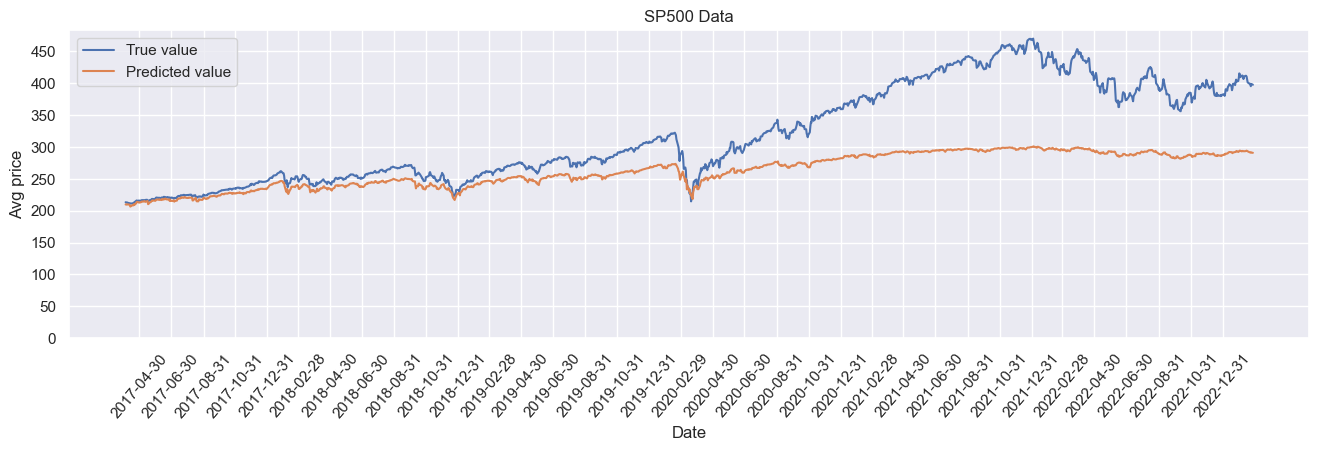

In [ ]:
sns.set(rc={'figure.figsize':(16, 4)})
sns.lineplot(x=test_dates, y=y_test_inv.flatten(), label=f'True value')
sns.lineplot(x=test_dates, y=best_pred_inv.flatten(), label=f'Predicted value')
plt.title('SP500 Data')
plt.xlabel('Date')
plt.ylabel('Avg price')
plt.xticks(pd.date_range(test_dates.min(), df_raw['Date'].max(), freq='2M'), rotation=50)
plt.yticks(range(0, 500, 50))
plt.gca().xaxis.set_major_formatter(date_form)
plt.show()

In [ ]:
best_pred = model.predict(y_train)
best_pred_inv = scaler_y.inverse_transform(best_pred)

y_train_inv = scaler_y.inverse_transform(y_train)

sns.set(rc={'figure.figsize':(16, 4)})
sns.lineplot(x=train_dates, y=y_train_inv.flatten(), label=f'True value')
sns.lineplot(x=train_dates, y=best_pred_inv.flatten(), label=f'Predicted value')
plt.title('SP500 Data')
plt.xlabel('Date')
plt.ylabel('Avg price')
plt.xticks(pd.date_range(test_dates.min(), df_raw['Date'].max(), freq='2M'), rotation=50)
plt.yticks(range(0, 500, 50))
plt.gca().xaxis.set_major_formatter(date_form)
plt.show()

TypeError: in user code:

    File "c:\Users\Reed Oken\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 2169, in predict_function  *
        return step_function(self, iterator)
    File "c:\Users\Reed Oken\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 2155, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\Reed Oken\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 2143, in run_step  **
        outputs = model.predict_step(data)
    File "c:\Users\Reed Oken\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 2111, in predict_step
        return self(x, training=False)
    File "c:\Users\Reed Oken\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\Reed Oken\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\layers\rnn\lstm.py", line 615, in call
        timesteps = input_shape[0] if self.time_major else input_shape[1]

    TypeError: Exception encountered when calling layer 'lstm' (type LSTM).
    
    'NoneType' object is not subscriptable
    
    Call arguments received by layer 'lstm' (type LSTM):
      • inputs=tf.Tensor(shape=<unknown>, dtype=float32)
      • mask=None
      • training=False
      • initial_state=None
